In [ ]:
# Required files:
    # SBML model file
    # CSV (TFVA) Flux bounds in format:
    #    id: ['lb', 'ub']
    # CSV ln concentration means
    # CSV ln concentration variance
    # CSV of TFVA bounds for ln concentrations
    # CSV of drG0_prime_mean
    # CSV of drG0_cov_sqrt
    # CSV of drG0_cov (drG0_cov_sqrt @ drG0_cov_sqrt.T)

In [1]:
import os.path as path
import numpy as np

from scripts.gen_model import gen_model
from scripts.gen_model import apply_physio_data

from scripts.reaction_utils import list_blocked_reactions

from scripts.metabolite_utils import remove_orphan_metabolites

from scripts.io import export_tmodel_cobra
from scripts.io import load_tmodel_cobra

from cobra.io import write_sbml_model

from thermo_flux.tools.drg_tools import reaction_balance
from thermo_flux.tools.drg_tools import calc_model_drG0prime

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [ ]:
# ln concentration means, cov is defined as follows:
# ln mean = column vector
# ln cov = row vector
# def _make_concentrations_distribution(
#         self,
#         metabolites: List[Metabolite],
#         concentrations: ConcentrationsPrior,
#     ) -> Tuple[Q, Q]:
#         """Construct the distribution over metabolite concentrations."""
#         log_conc_mean = qvector(
#             [
#                 Q(concentrations.get(m.miriam_id, m.compartment).log_mean)
#                 for m in metabolites
#             ]
#         )
#         log_conc_cov = Q(
#             np.diag(
#                 np.square(
#                     qrvector(
#                         [
#                             Q(concentrations.get(m.miriam_id, m.compartment).log_std)
#                             for m in metabolites
#                         ]
#                     ).m
#                 )
#             )
#         )

In [2]:
INPUT_MODEL = "datafiles/model.xlsx"
INPUT_KEGGS = "datafiles/ecoli_kegg_id.csv"
INPUT_REED = "regression/reed.csv"
INPUT_INCHI = "regression/InChIs.csv"
INPUT_GAMS = "regression/model_Ecoli_from-gams.xlsx"
INPUT_EXP_DATA = "regression/allPhysioData_formatted_forGSM_20230831.csv"
INPUT_EXP_CONC = "regression/allConcRange_20230912.csv"
INPUT_METABOLOMICS = "regression/metabolomics-Kochanowski_20230925.csv"

MODEL_NAME = "ecoli"

OUTPUT_DIR = "tfs"
OUTPUT_NAME = f"tfs_log"
OUTPUT_LOG = f"{OUTPUT_DIR}{path.sep}{OUTPUT_NAME}_log.txt"

CONDITIONS_TO_REGRESS = ["WT-Glc_I"]

INCLUDE_CO2 = True
INCLUDE_O2 = True
ALLOW_OTHER_EXCRETION = False
RELAX_EXP_FLUX_BOUNDS = 2.0

In [50]:
tmodel = gen_model(MODEL_NAME, INPUT_MODEL, INPUT_KEGGS, INPUT_REED, INPUT_INCHI, INPUT_GAMS, OUTPUT_LOG, True, True)
tmodel = apply_physio_data(tmodel, CONDITIONS_TO_REGRESS[0], INPUT_EXP_DATA, INPUT_EXP_CONC, INPUT_METABOLOMICS, INPUT_GAMS, RELAX_EXP_FLUX_BOUNDS, INCLUDE_CO2, INCLUDE_O2, allow_other_excr=False, output_log=OUTPUT_LOG)

['Parameters', 'Exchange reactions', 'Reactions', 'Biomass Composition', 'Transmembrane reactions', 'Metabolites', 'references', 'Transmembrane_reactions_reed', 'Transmembrane reactions_Orth', 'Transmembrane reactions old', 'Sheet3', 'log', 'subsystems']
*** Reading data from Reactions ***
unknown metabolite '2dhglcn[c]' created
unknown metabolite 'nadh[c]' created
unknown metabolite 'glcn[c]' created
unknown metabolite 'nad[c]' created
unknown metabolite 'nadph[c]' created
unknown metabolite 'nadp[c]' created
unknown metabolite '2dhguln[c]' created
unknown metabolite 'idon-L[c]' created
unknown metabolite '3hcinnm[c]' created
unknown metabolite 'o2[c]' created
unknown metabolite 'dhcinnm[c]' created
unknown metabolite 'h2o[c]' created
unknown metabolite '3hpppn[c]' created
unknown metabolite 'dhpppn[c]' created
unknown metabolite 'phthr[c]' created
unknown metabolite '4hthr[c]' created
unknown metabolite 'pi[c]' created
unknown metabolite '5dglcn[c]' created
unknown metabolite 'ru5p-D

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


2dhglcn_c NOTHING DONE!
nadh_c NOTHING DONE!
glcn_c NOTHING DONE!
nad_c NOTHING DONE!
nadph_c NOTHING DONE!
nadp_c NOTHING DONE!
2dhguln_c NOTHING DONE!
idon-L_c NOTHING DONE!
3hcinnm_c NOTHING DONE!
o2_c NOTHING DONE!
dhcinnm_c NOTHING DONE!
h2o_c NOTHING DONE!
3hpppn_c NOTHING DONE!
dhpppn_c NOTHING DONE!
phthr_c NOTHING DONE!
4hthr_c NOTHING DONE!
pi_c NOTHING DONE!
5dglcn_c NOTHING DONE!
ru5p-D_c NOTHING DONE!
ara5p_c NOTHING DONE!
ACP_c NOTHING DONE!
atp_c NOTHING DONE!
ttdca_c NOTHING DONE!
amp_c NOTHING DONE!
myrsACP_c NOTHING DONE!
ppi_c NOTHING DONE!
ttdcea_c NOTHING DONE!
tdeACP_c NOTHING DONE!
hdca_c NOTHING DONE!
palmACP_c NOTHING DONE!
hdcea_c NOTHING DONE!
hdeACP_c NOTHING DONE!
ocdcea_c NOTHING DONE!
octeACP_c NOTHING DONE!
dtdp4aaddg_c NOTHING DONE!
unagamu_c NOTHING DONE!
dtdp_c NOTHING DONE!
unagamuf_c NOTHING DONE!
arbt6p_c NOTHING DONE!
g6p_c NOTHING DONE!
hqn_c NOTHING DONE!
4abut_c NOTHING DONE!
akg_c NOTHING DONE!
glu-L_c NOTHING DONE!
sucsal_c NOTHING DONE!
4abu

In [51]:
blocked_p = list_blocked_reactions(tmodel, CONDITIONS_TO_REGRESS[0], OUTPUT_LOG, 1, False)
print(len(blocked_p))

tmodel.remove_reactions(blocked_p, remove_orphans=True)
remove_orphan_metabolites(tmodel)
for rxn in tmodel.reactions:
    reaction_balance(rxn, balance_charge=True, balance_mg=False)
tmodel.update_thermo_info(fit_unknown_dfG0=True)

['3HCINNMH', '3HPPPNH', '4HTHRS', '5DGLCNR', 'AADDGT', 'AB6PGH', 'ACACCT', 'ACACT1r', 'ACBIPGT', 'ACGAMT', 'ACMAMUT', 'ACNML', 'ACONMT', 'ACPS1', 'ADHEr', 'ADK4', 'ADNCYC', 'ADOCBIK', 'ADOCBLS', 'AGDC', 'AGMT', 'AHC', 'AHCYSNS', 'ALCD19', 'ALDD19x', 'ALLTAH', 'alltn', 'ALTRH', 'AMANAPE', 'AMANK', 'AMAOTr', 'AMMQT82', 'AMPMS', 'AOXSr', 'AP4AH', 'AP5AH', 'ARAI', 'ARGDC', 'BTS2', 'BUTCT', 'CBIAT', 'CBLAT', 'CDPMEK', 'CHRPL', 'CINNDO', 'CPPPGO', 'CRNBTCT', 'CRNCBCT', 'CRNCDH', 'CYANST', 'CYNTAH', 'DBTSr', 'DDGALK', 'DDGLK', 'DDPGALA', 'DHBD', 'DHBSr', 'DHCIND', 'DHCINDO', 'DHNAOT', 'DHPPD', 'DHPTDC', 'DMATT', 'DMQMT', 'DOGULNR', 'DXPRIi', 'DXPS', 'DXYLK', 'E4PD', 'ECAPEC', 'EDTXS3', 'EDTXS4', 'ENTCS', 'FAO3', 'FAO4', 'FCI', 'FCLK', 'FCLPA', 'FCLT', 'FFSD', 'FHL', 'G1PTT', 'G1SATi', 'GALCTD', 'GALCTND', 'GALKr', 'GALS3', 'GDMANE', 'GLCRAL', 'GLCRD', 'GLTPD', 'glucys', 'GLUTRR', 'GLUTRS', 'GMAND', 'GOFUCR', 'GP4GH', 'GPDDA1', 'GPDDA3', 'GPDDA5', 'GRTT', 'GTHOr', 'GTHS', 'GUI1', 'GUI2', 'HBZO

In [52]:
export_tmodel_cobra(tmodel, f"{OUTPUT_DIR}{path.sep}test_model.json")
cobra_model = load_tmodel_cobra(f"{OUTPUT_DIR}{path.sep}test_model.json")
cobra_sbml = write_sbml_model(cobra_model, f"{OUTPUT_DIR}{path.sep}test.sbml")

[{'id': '2dhglcn_c', 'name': '2dhglcn_c', 'compartment': 'c', 'charge': -1, 'formula': 'H8'}, {'id': 'nadh_c', 'name': 'nadh_c', 'compartment': 'c', 'charge': -2, 'formula': 'H27'}, {'id': 'glcn_c', 'name': 'glcn_c', 'compartment': 'c', 'charge': -1, 'formula': 'H11'}, {'id': 'nad_c', 'name': 'nad_c', 'compartment': 'c', 'charge': -1, 'formula': 'H26'}, {'id': 'nadph_c', 'name': 'nadph_c', 'compartment': 'c', 'charge': -4, 'formula': 'H26'}, {'id': 'nadp_c', 'name': 'nadp_c', 'compartment': 'c', 'charge': -3, 'formula': 'H25'}, {'id': '2dhguln_c', 'name': '2dhguln_c', 'compartment': 'c', 'charge': -1, 'formula': 'H9'}, {'id': 'idon-L_c', 'name': 'idon-L_c', 'compartment': 'c', 'charge': -1, 'formula': 'H11'}, {'id': 'o2_c', 'name': 'o2_c', 'compartment': 'c', 'charge': 0, 'formula': 'H0'}, {'id': 'h2o_c', 'name': 'h2o_c', 'compartment': 'c', 'charge': 0, 'formula': 'H2'}, {'id': 'pi_c', 'name': 'pi_c', 'compartment': 'c', 'charge': -2, 'formula': 'H1'}, {'id': '5dglcn_c', 'name': '5dgl

In [57]:
from thermo_flux.tools.drg_tools import calc_dfG0prime
from cobra.util.array import create_stoichiometric_matrix

def get_drG0_values(tmodel):
    drg0_prime_mean = [r.drG0prime + r.drGtransport for r in tmodel.reactions]
    #drg0_cov_sqrt = tmodel._drG0_cov_sqrt # Matrix
    
    #dfG0_mean, dfG0prime_mean, dfG0_cov_sqrt, unknowns_basis = calc_dfG0prime(tmodel, fit_unknown_dfG0=True)

    #S = create_stoichiometric_matrix(tmodel)
    #print(S)
    #drg0_cov_sqrt = (S.T @ dfG0_cov_sqrt)
    drg0_cov_sqrt = tmodel._drG0_cov_sqrt @ tmodel._drG0_cov_sqrt.T
    r, c = drg0_cov_sqrt.shape
    print(f"{r}, {c}")
    drg0_cov = drg0_cov_sqrt @ drg0_cov_sqrt.T # Matrix

    return (drg0_prime_mean, drg0_cov_sqrt, drg0_cov)

In [58]:
drgs = get_drG0_values(tmodel)

623, 623


In [59]:
test_df = pd.DataFrame(data=drgs[1])
print(test_df)

          0             1          2             3             4    \
0    0.894179  7.814424e-01   0.894179  7.814423e-01  9.306749e-03   
1    0.781442  7.814424e-01   0.781442  7.814424e-01 -7.670267e-09   
2    0.894179  7.814424e-01  11.390074  1.127734e+01  9.305474e-03   
3    0.781442  7.814424e-01  11.277337  1.127734e+01 -1.282016e-06   
4    0.009307 -7.670267e-09   0.009305 -1.282016e-06  2.969092e+00   
..        ...           ...        ...           ...           ...   
618  0.000000  0.000000e+00   0.000000  0.000000e+00  0.000000e+00   
619  0.000000  0.000000e+00   0.000000  0.000000e+00  0.000000e+00   
620  0.000000  0.000000e+00   0.000000  0.000000e+00  0.000000e+00   
621  0.000000  0.000000e+00   0.000000  0.000000e+00  0.000000e+00   
622  0.048981 -2.046974e-16   0.048981  5.665607e-15 -1.560542e-01   

              5             6             7             8             9    \
0   -6.713537e-03 -6.713556e-03 -6.713556e-03 -6.713630e-03 -6.713643e-03   
1   -

In [10]:
from scripts.metabolite_utils import conc_to_logdist
from scripts.metabolite_utils import graph_ln_dist

log_dists = [conc_to_logdist(m.lower_bound.m, m.upper_bound.m, frac_of_area=0.8) for m in tmodel.metabolites]
conc_log_means = [x.log_mean for x in log_dists]
conc_log_cov = [np.square(x.log_std) for x in log_dists]

print(conc_log_cov)

[np.float64(12.912763524740518), np.float64(15.997857452495984), np.float64(12.1223630436162), np.float64(22.979532464874225), np.float64(15.983059604037184), np.float64(6.518650951604047), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(0.18372012947828406), np.float64(0.0), np.float64(0.007579429518904076), np.float64(12.912763524740518), np.float64(1.9826524880597982), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(1.6723757129529568), np.float64(12.912763524740518), np.float64(15.076570129003569), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(12.912763524740518), np.float64(0.08502403714469552), np.float64(1.405267903905904), np.float64(12.912763524740518), np.float64(2.691457216

In [11]:
from scripts.gen_model import run_fva

bounds = run_fva(tmodel, OUTPUT_LOG)


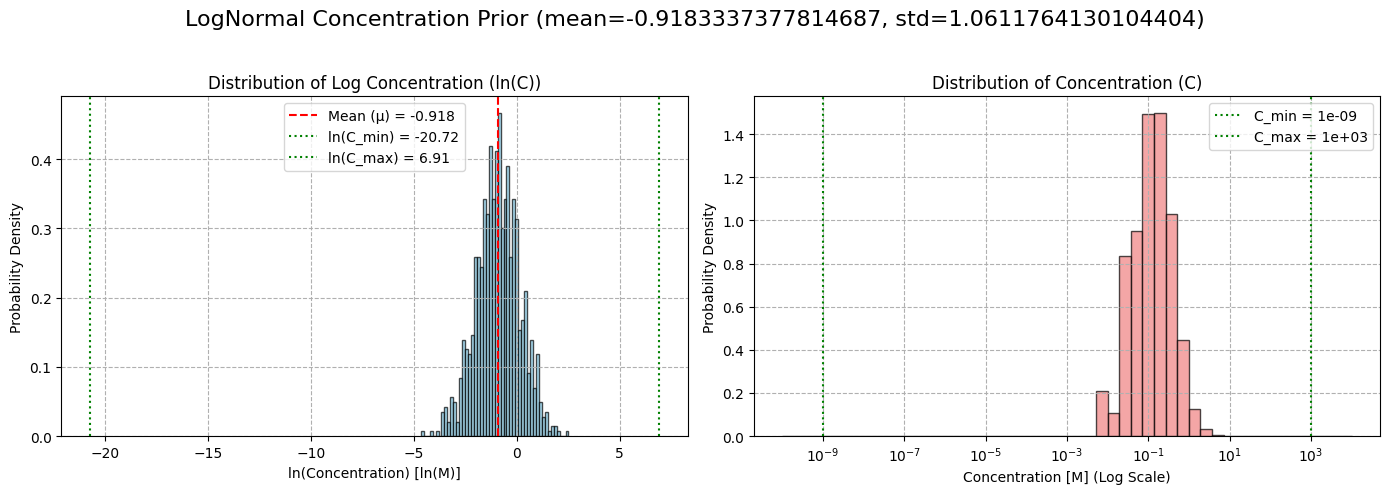

In [12]:
graph_ln_dist(log_dists[231].log_mean, log_dists[231].log_std)

In [60]:
# Write required data to CSV
import pandas as pd

r_ids = [r.id for r in tmodel.reactions]

r_indices = [tmodel.reactions.index(r) for r in tmodel.reactions]
m_indices = [tmodel.metabolites.index(m) for m in tmodel.metabolites]

flux_bounds_df = pd.DataFrame(data=bounds,index=r_ids, columns=['lb', 'ub'])
flux_bounds_df.to_csv("tfs/flux_bounds_test.csv")

drg0_prime_mean_df = pd.DataFrame(data=drgs[0], index=r_indices, columns=['0'])
drg0_cov_sqrt_df = pd.DataFrame(data=drgs[1])
drg0_cov_df = pd.DataFrame(data=drgs[2])

drg0_prime_mean_df.to_csv("tfs/drg0pm_test.csv")
drg0_cov_sqrt_df.to_csv("tfs/drg0cs_test.csv")
drg0_cov_df.to_csv("tfs/drg0c_test.csv")

log_mean_df = pd.DataFrame(data=np.array(conc_log_means), index=m_indices, columns=['0'])
log_cov_df = pd.DataFrame(data=np.array(conc_log_cov), index=m_indices, columns=['0'])

log_mean_df.to_csv("tfs/lm_test.csv")
log_cov_df.to_csv("tfs/lc_test.csv")

In [61]:
from scripts.tfs import preprocess
from scripts.tfs import thermospace_mod
from scripts.tfs import tbasis_mod

In [24]:
from importlib import reload


In [44]:
reload(preprocess)

<module 'scripts.tfs.preprocess' from '/home/laurens/MSC-Thermo/scripts/tfs/preprocess.py'>

In [16]:
ranktol=1e-5

In [62]:
prep = preprocess.Preprocess(
    cobra_file="tfs/test.sbml",
    vbound_file="tfs/flux_bounds_test.csv",
    logconcmean_file="tfs/lm_test.csv",
    logconcvar_file="tfs/lc_test.csv",
    lncbounds_file=None,
    drG0file="tfs/drg0pm_test.csv",
    drGcovsqrtfile="tfs/drg0cs_test.csv",
    drG0covfile=None#"tfs/drg0c_test.csv",
)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


623
[]
[619, 523, 618, 517, 516, 525, 622, 567, 524, 522, 518, 520, 519, 521]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 2

In [ ]:
thermodynamic_space = thermospace_mod.ThermodynamicSpaceMod(
    prep.Sconstrained,
    prep.rid_constrained,
    prep.model.metabolites,
    prep.drg0_prime_mean,
    prep.drg0_prime_cov_sqrt,
    prep.log_conc_cov,
    prep.log_conc_mean,
)


problem = pta.PmoProblem(prep.model, thermodynamic_space, tbasis, solver="GUROBI")

In [ ]:
tbasis = tbasis_mod.ThermodynamicSpaceBasismod(
    thermodynamic_space,
    explicit_log_conc=False,
    explicit_drg0=False,
    explicit_drg=True,
    min_eigenvalue=1e-10,
    ranktol=ranktol,
    ignoreconc_met_idx=prep.ignoreconc_met_idx,
)